In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from concurrent.futures import ThreadPoolExecutor
import os
from matplotlib import pyplot as plt
from data_generation import *
import glob


import warnings
warnings.filterwarnings('ignore')

In [3]:
# TODO: Hyperparameters search for omp

##* Data Generation
##* N (columns of dictionary) = 10k
##* d (dimension of signal) = 300, 600, 900, 1200, 1500, 2000
##* X_{ij} \sim N(0, \frac{1}{n}) (The same as N(0,1) them normalize)
##* m (sparse level) = 20, 40, 80

##* Noise level = 0.01, 0.05, 0.1, 0.2, 0.5

N = 1000
d = 400
m = 40
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.5]
trial_num = 10
cv_num = 5

In [4]:
##! Task 1: Given signal, dictionary, sparsity level and noise level, use testset (10% of the whole signal) to find the best K(depth) for omp



seed = 0
Data_Geneartor = GaussianDataGenerator(N, d, m, 0.05, seed)

true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()

In [5]:
def cv_split(true_signal, dictionary, cv_num):
    true_signal = true_signal.ravel()
    # true_signal is (1200, 1) and dictionary is (1200, 10000), cv both signal and dictionary by rows
    cv_signal = np.split(true_signal, cv_num)
    cv_dictionary = np.split(dictionary, cv_num)
    # Get the list of train and test set
    cv_res = []
    for i in range(cv_num):
        train_signal = np.concatenate(cv_signal[:i] + cv_signal[i + 1:], axis = 0)
        train_dictionary = np.concatenate(cv_dictionary[:i] + cv_dictionary[i + 1:], axis=0)
        test_signal = cv_signal[i]
        test_dictionary = cv_dictionary[i]
        cv_res.append((train_signal, train_dictionary, test_signal, test_dictionary))
    return cv_res

In [6]:
# We need a OMP class to do the cross validation and it need a fit and score function

# ? The algorithm is not optimized, it is just for a quick demonstration
def cal_cv_error(algorithm, cv_num, signal, dictionary):
    cv_res = cv_split(signal, dictionary, cv_num)
    error_lst = []
    for i in range(cv_num):
        train_signal, train_dictionary, test_signal, test_dictionary = cv_res[i]
        algorithm.fit(train_signal, train_dictionary)
        error_lst.append(algorithm.score(test_signal, test_dictionary))
    return np.mean(error_lst)

In [7]:
from algorithms import OMP

cal_cv_error(OMP(10), 10, perturbed_signal, dictionary)

0.0030546505329837265

In [8]:
##! Task 2: Relationship between best K and noise level (std)

##! Task 3: Relationship between Test Error and noise level (std)

# Choose the best K for each noise level

def cv_best_K(signal, dictionary, cv_num, K_lst):
    K_cv_error = []
    for K in K_lst:
        OMP_tmp = OMP(K, ignore_warning=True)
        K_cv_error.append(cal_cv_error(OMP_tmp, cv_num, signal, dictionary))
    lowest_error = np.min(K_cv_error)
    lowest_error_K = K_lst[np.argmin(K_cv_error)]
    return lowest_error, lowest_error_K, K_cv_error

cv_best_K(perturbed_signal, dictionary, 5, np.arange(2, 22, 2))

(0.003184988568140968,
 12,
 [0.0038866347899150014,
  0.0036206407258789425,
  0.003516773507850524,
  0.003529572080913495,
  0.0033409991742988305,
  0.003184988568140968,
  0.0032837326742993986,
  0.0033955533098516434,
  0.0033193742131390125,
  0.0033919112519604786])

In [63]:
# Improvement: Save the result to a file

if not os.path.exists('./memory'):
    os.mkdir('./memory')

def cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, K_lst, trial_num, output_filename = None):
    if output_filename is None:
        output_filename = str(N) + '_' + str(d) + '_' + str(m) + '_' + str(trial_num) + '_' + str(cv_num) + '.pkl'
    res_log = {
        'parameters': {'N': N, 'd': d, 'm': m, 'noise_level_lst': noise_level_lst, 'cv_num': cv_num, 'trial_num': trial_num, 'K_lst': K_lst},
        'noise_level_best_K': [],
        'noise_level_lowest_MSE': [],
        'log': []
    }
    noise_level_best_K = []
    noise_level_lowest_MSE = []
    for noise_level in noise_level_lst:
        print("Cross validating K under noise level: ", noise_level)
        trials_best_K_tmp = []
        MSE_loweset_K_temp = []
        for trial in range(trial_num):
            Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, trial)
            true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
            lowest_error, lowest_error_K, cv_err_lst = cv_best_K(perturbed_signal, dictionary, cv_num, K_lst)
            trials_best_K_tmp.append(lowest_error_K)
            MSE_loweset_K_temp.append(lowest_error)
            print("Trial: ", trial, " Best K: ", lowest_error_K, " Lowest Error: ", lowest_error)
            log_tmp = {'noise_level': noise_level, 'trial': trial, 'data': Data_Geneartor, 'cv_error_lst': cv_err_lst, 
                       'lowest_error': lowest_error, 'lowest_error_K': lowest_error_K}
            res_log['log'].append(log_tmp)
        noise_level_best_K.append(np.mean(trials_best_K_tmp))
        noise_level_lowest_MSE.append(np.mean(MSE_loweset_K_temp))
        print("Average best K for noise level: ", noise_level, " is: ", np.mean(trials_best_K_tmp), " with MSE: ", np.mean(MSE_loweset_K_temp))
    res_log['noise_level_best_K'] = noise_level_best_K
    res_log['noise_level_lowest_MSE'] = noise_level_lowest_MSE
    with open('./memory/' + output_filename, 'wb') as f:
        pkl.dump(res_log, f)
    print("Finished!")
    print("Log file saved to: ", './memory/' + output_filename)
    return noise_level_best_K, noise_level_lowest_MSE, res_log

In [11]:
# Check if it is working
N = 1000
d = 500
m = 20
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.3]
trial_num = 5
# ? Maybe we need to increase the trial number  
cv_num = 5
# ? Is cv necessary? 

noise_level_best_K, noise_level_lowest_MSE, res_log = cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, np.arange(1, 41, 1), trial_num, 'test.pkl')

Cross validating K under noise level:  0
Trial:  0  Best K:  20  Lowest Error:  2.554542186469786e-33
Trial:  1  Best K:  22  Lowest Error:  2.3910833563381284e-33
Trial:  2  Best K:  20  Lowest Error:  3.7145179004196697e-33
Trial:  3  Best K:  20  Lowest Error:  2.5832073674691246e-33
Trial:  4  Best K:  20  Lowest Error:  2.0209371887899746e-33
Average best K for noise level:  0  is:  20.4  with MSE:  2.6528575998973364e-33
Cross validating K under noise level:  0.01
Trial:  0  Best K:  15  Lowest Error:  0.00011851400350552405
Trial:  1  Best K:  16  Lowest Error:  0.0001075591921728747
Trial:  2  Best K:  23  Lowest Error:  0.0001337261291720118
Trial:  3  Best K:  17  Lowest Error:  0.00012567850974138
Trial:  4  Best K:  18  Lowest Error:  0.00012408409325872287
Average best K for noise level:  0.01  is:  17.8  with MSE:  0.00012191238557010268
Cross validating K under noise level:  0.05
Trial:  0  Best K:  19  Lowest Error:  0.0027676853710016684
Trial:  1  Best K:  7  Lowest E

Text(0, 0.5, 'Best iteration number')

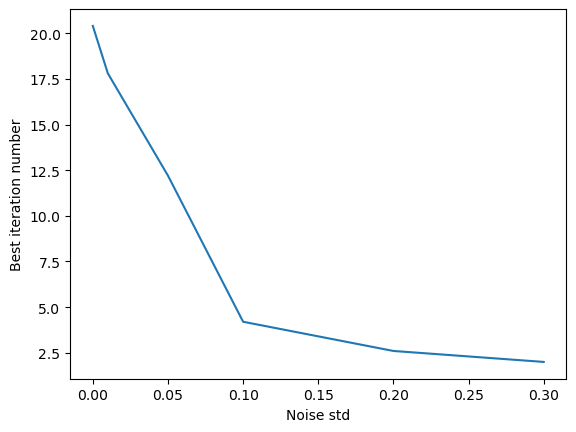

In [58]:
plt.plot(noise_level_lst, noise_level_best_K)
plt.xlabel("Noise std")
plt.ylabel("Best iteration number")

Text(0, 0.5, 'CV prediction error for best K')

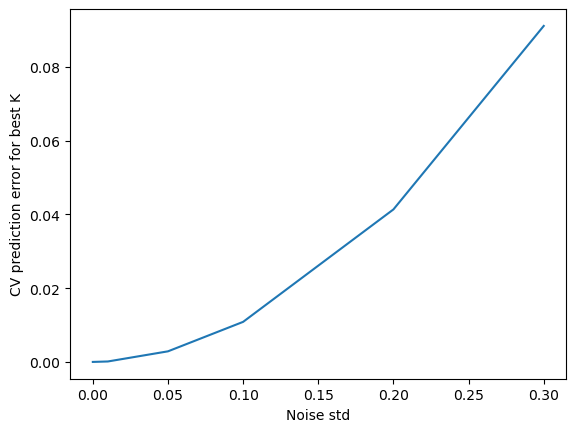

In [56]:
plt.plot(noise_level_lst, noise_level_lowest_MSE)
plt.xlabel("Noise std")
plt.ylabel("CV prediction error for best K")


Text(0, 0.5, 'CV prediction error')

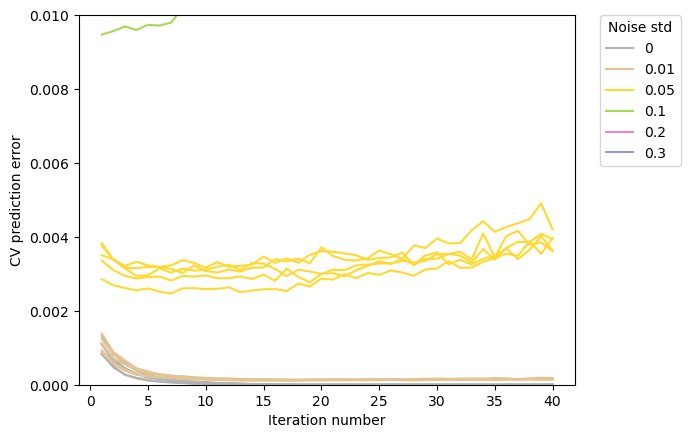

In [62]:
# extract noise level, trial, cv_error_lst from res_log

tmp = []
for i in range(len(res_log)):
    tmp.append([res_log[i]['noise_level'], res_log[i]['trial'], res_log[i]['cv_error_lst']])
    
K_lst = np.arange(1, 41, 1).tolist()


fig, ax = plt.subplots()
# Plot the cv error for each K for each noise level
for i in range(len(tmp)):    
    if i % trial_num == 0:
        label = tmp[i][0]
    else:
        label = ""
    # Assign color to different noise level
    plt.plot(K_lst, tmp[i][2], label = label, color = plt.cm.Set2_r(i // trial_num))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.get_legend().set_title("Noise std")

plt.ylim([0, 0.01])

plt.xlabel("Iteration number")
plt.ylabel("CV prediction error")

It should be working, testing with the following parameters:

$$X \in \mathbb{R}^{n\times p}$$
$$p = 10000$$
$$n = 300, 600, 900, 1200, 1500, 2000$$
$$|\beta|_0 = 20, 40, 80$$
```

In [73]:
N = 10000
d = 300
m = 40
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
trial_num = 5
cv_num = 5
K_lst = np.arange(1, m+20+1, 1).tolist()

noise_level_best_K, noise_level_lowest_MSE, res_log = cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, K_lst, trial_num)

Cross validating K under noise level:  0
Trial:  0  Best K:  41  Lowest Error:  5.8383677220285024e-30
Trial:  1  Best K:  41  Lowest Error:  2.1094335845112276e-30
Trial:  2  Best K:  40  Lowest Error:  2.675366795048631e-30
Trial:  3  Best K:  42  Lowest Error:  2.314720991945606e-30
Trial:  4  Best K:  41  Lowest Error:  4.321317026569046e-30
Average best K for noise level:  0  is:  41.0  with MSE:  3.451841224020603e-30
Cross validating K under noise level:  0.01
Trial:  0  Best K:  45  Lowest Error:  0.00010730015814312488
Trial:  1  Best K:  24  Lowest Error:  0.00015905298093634826
Trial:  2  Best K:  37  Lowest Error:  0.0001336499775637396
Trial:  3  Best K:  47  Lowest Error:  0.00012674432663336668
Trial:  4  Best K:  36  Lowest Error:  0.00012505895173621127
Average best K for noise level:  0.01  is:  37.8  with MSE:  0.00013036127900255815
Cross validating K under noise level:  0.05
Trial:  0  Best K:  24  Lowest Error:  0.0031174362678109296
Trial:  1  Best K:  40  Lowest

In [23]:
def makeplots(res_log, savefig = True):
    if not os.path.exists('./images'):
        os.makedirs('./images')
        
    # res_log can either be a object name or path to the file
    if isinstance(res_log, str):
        path = os.path.join('./memory/', res_log)
        with open(path, 'rb') as f:
            res_log = pkl.load(f)
    
    # Extract parameters
    parameters = res_log['parameters']
    noise_level_best_K = res_log['noise_level_best_K']
    noise_level_lowest_MSE = res_log['noise_level_lowest_MSE']
    
    K_lst = parameters['K_lst']
    trial_num = res_log['parameters']['trial_num']
    print('Parameters: ', parameters)
    
    # Get folder name for saving images
    imgfolderPath = str(parameters['N']) + '_' + str(parameters['d']) + '_' + str(parameters['m']) + '_' + str(parameters['trial_num']) + '_' + str(parameters['cv_num'])
    if savefig:
        if not os.path.exists('./images/' + imgfolderPath):
            os.makedirs('./images/' + imgfolderPath)
    
    # Generate plots
    ## First plot: Iteration number vs. CV prediction error for each noise level
    noise_level_lst = parameters['noise_level_lst']
    tmp = []
    for i in range(len(res_log['log'])):
        tmp.append([res_log['log'][i]['noise_level'], res_log['log'][i]['trial'], res_log['log'][i]['cv_error_lst']])
    fig, ax = plt.subplots()
    # Plot the cv error for each K for each noise level
    for i in range(len(tmp)):    
        if i % trial_num == 0:
            label = tmp[i][0]
        else:
            label = ""
        # Assign color to different noise level
        plt.plot(K_lst, tmp[i][2], label = label, color = plt.cm.Set2_r(i // trial_num))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    ax.get_legend().set_title("Noise std")
    plt.ylim([0, 0.5])
    
    plt.xlabel("Iteration number")
    plt.ylabel("CV prediction error")
    plt.title("CV prediction error for each noise level with m = " + str(parameters['m']) + " and d = " + str(parameters['d']))
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/cv_error.png', dpi=200, bbox_inches='tight')
    plt.show()

    ## Second plot: Noise std vs. best iteration number
    plt.plot(noise_level_lst, noise_level_best_K)
    plt.title("Best iteration number for each noise level with m = " + str(parameters['m']) + " and d = " + str(parameters['d']))
    plt.xlabel("Noise std")
    plt.ylabel("Best iteration number")
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/noise_vs_bestK.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    ## Third plot: Noise std vs. CV prediction error for best iteration number
    plt.plot(noise_level_lst, noise_level_lowest_MSE)
    plt.xlabel("Noise std")
    plt.ylabel("CV prediction error for best K")
    plt.title("CV prediction error for best iteration number for each noise level with m = " + str(parameters['m']) + " and d = " + str(parameters['d']))
    if savefig:
        plt.savefig('./images/' + imgfolderPath + '/noise_vs_bestMSE.png', dpi=200, bbox_inches='tight')
    plt.show()

# Extracing All information
pkl_files = glob.glob("memory/*.pkl")
parameter_dict_list = []
for i in range(len(pkl_files)):
    with open(pkl_files[i], 'rb') as f:
        res_log = pkl.load(f)
    makeplots(res_log, savefig = True)


In [ ]:
# Intersting Phenomenon:
# Best CV error almost equals to the square of noise_level